# Задание 1. A/B–тестирование

## 1.1 Условие

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

In [80]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from statsmodels.stats.proportion import proportions_ztest
from urllib.parse import urlencode
import requests

large = 22; med = 16; small = 12

params = {'axes.titlesize': large,
          'legend.fontsize': med,
          'figure.figsize': (16, 10),
          'axes.labelsize': med,
          'axes.titlesize': med,
          'xtick.labelsize': med,
          'ytick.labelsize': med,
          'figure.titlesize': large}

plt.rcParams.update(params)

plt.style.use('seaborn-whitegrid')
sns.set_style("white")

## 1.2 Входные данные

В качестве входных данных вы имеете 4 csv-файла:

1. **groups.csv** – файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 

2. **groups_add.csv** – дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных

3. **active_studs.csv** – файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента. 

4. **checks.csv** – файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [81]:
Url = "https://cloud-api.yandex.net/v1/disk/public/resources/download"
public_key = "https://disk.yandex.ru/d/XNdgle4oWXrLCA"
file_paths = {
    "groups.csv": "/groups.csv",
    "group_add.csv": "/group_add.csv",
    "active_studs.csv": "/active_studs.csv",
    "checks.csv": "/checks.csv"
}

# Функция для получения прямой ссылки
def get_download_link(public_key, file_path):
    response = requests.get(Url, params={"public_key": public_key, "path": file_path})
    if response.status_code == 200:
        return response.json()["href"]
    
# Функция для скачивания файлов
def download_file(file_name, download_url):
    response = requests.get(download_url, allow_redirects=True)
    if response.status_code == 200:
        with open(file_name, "wb") as file:
            file.write(response.content)

for file_name, file_path in file_paths.items():
    download_link = get_download_link(public_key, file_path)
    if download_link:
        download_file(file_name, download_link)

In [82]:
groups = pd.read_csv("groups.csv", sep=";")
group_add = pd.read_csv("group_add.csv", sep=",")  
active_studs = pd.read_csv("active_studs.csv", sep=",")
checks = pd.read_csv("checks.csv", sep=";")

In [83]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [84]:
group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [85]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [86]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [87]:
# Объединение основной и дополнительной информации о группах
groups_combined = pd.concat([groups, group_add], ignore_index=True)

In [88]:
print(f"Дубликатов: {groups_combined.duplicated().sum()} и наличие пропусков: {groups_combined.isnull().any().any()}")

Дубликатов: 0 и наличие пропусков: False


In [89]:
checks = checks.rename(columns={'student_id': 'id'})
active_studs = active_studs.rename(columns={'student_id': 'id'})

In [90]:
# Добавим активным индикатор активности
active_studs['active'] = 1

In [91]:
df = groups_combined.merge(active_studs, how='left', on='id').fillna(0)

In [92]:
full = df.merge(checks, how='left', on='id').fillna(0)

In [118]:
# Проверим пользователей которые не были активны но при этом совершали оплаты
print(f'Пользователи попавшие в данные по ошибке {full.query("active != 1 and rev > 0").count()["id"]}')

Пользователи попавшие в данные по ошибке 149


In [119]:
# Отберем только тех кто был активен во время эксперимента
full_active = full.query('active == 1')

In [120]:
full_active.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8341 entries, 1 to 74562
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      8341 non-null   int64  
 1   grp     8341 non-null   object 
 2   active  8341 non-null   float64
 3   rev     8341 non-null   float64
dtypes: float64(2), int64(1), object(1)
memory usage: 325.8+ KB


## 1.3.1 Метрики

1. **Конверсия в оплату** показывает эффективность стимулирования пользователей к совершению платежа.  
2. **ARPU** (Средний платеж по всем пользователям) отражает общую экономическую эффективность изменения.  
3. **ARPPU** (Средний платеж по платящим пользователям) помогает оценить влияние на платежеспособных пользователей.

In [102]:
# Общее количество юзеров, платящие пользователи, общая выручка
metrics = full_active.groupby('grp').agg(
    total_users=('id', 'count'),
    paying_users=('rev', lambda x: (x > 0).sum()),
    total_revenue=('rev', 'sum')
).reset_index()

In [103]:
# Расчет ключевых метрик
# конверсия в платящего 
# средний чек на пользователя
# средний чек на плятящего пользователя
metrics['conversion'] = metrics['paying_users'] / metrics['total_users']
metrics['arpu'] = metrics['total_revenue'] / metrics['total_users']
metrics['arppu'] = metrics['total_revenue']/metrics['paying_users']

In [104]:
for index, row in metrics.iterrows():
        print(f"Группа: {row['grp']}")
        print(f"Всего пользователей: {row['total_users']}")
        print(f"Платящие пользователи: {row['paying_users']}")
        print(f"Общий доход: {row['total_revenue']:.2f}")
        print(f"Конверсия: {row['conversion'] * 100:.2f}%")
        print(f"ARPU: {row['arpu']:.2f}")
        print(f"ARPPU: {row['arppu']:.2f}")
        print("-" * 30) 

Группа: A
Всего пользователей: 1538
Платящие пользователи: 78.0
Общий доход: 72820.00
Конверсия: 5.07%
ARPU: 47.35
ARPPU: 933.59
------------------------------
Группа: B
Всего пользователей: 6803
Платящие пользователи: 314.0
Общий доход: 394974.00
Конверсия: 4.62%
ARPU: 58.06
ARPPU: 1257.88
------------------------------


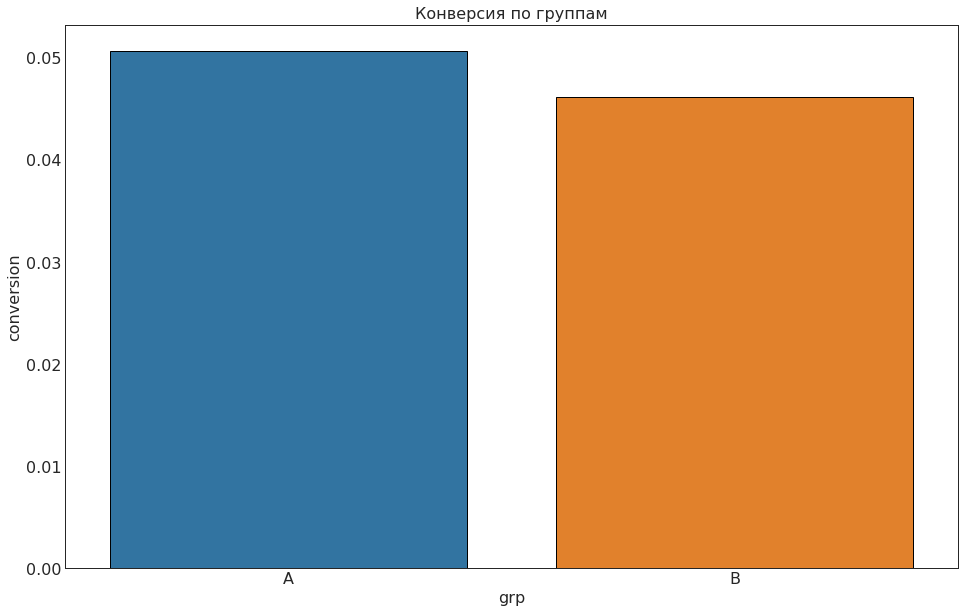

In [105]:
sns.barplot(x='grp', y='conversion', data=metrics, edgecolor='black')
plt.title('Конверсия по группам')
plt.show()

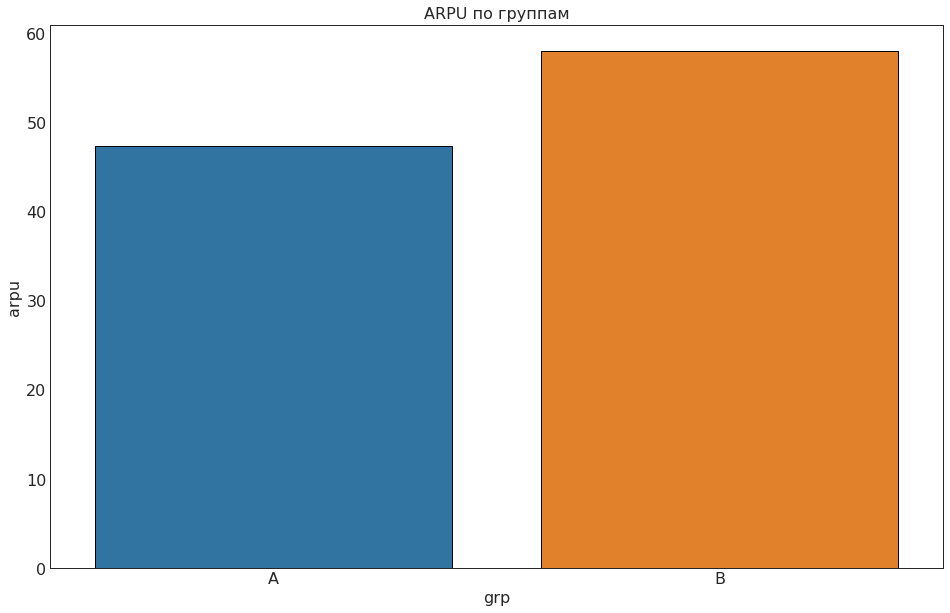

In [106]:
sns.barplot(x='grp', y='arpu', data=metrics, edgecolor='black')
plt.title('ARPU по группам')
plt.show()

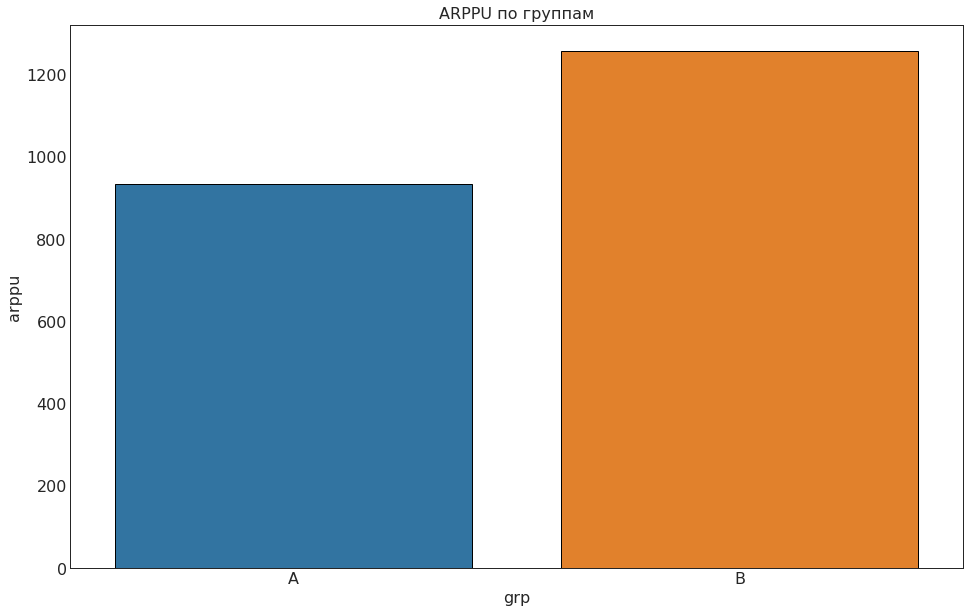

In [107]:
sns.barplot(x='grp', y='arppu', data=metrics, edgecolor='black')
plt.title('ARPPU по группам')
plt.show()

In [121]:
#проверим распределение оплат
active_us = full_active[full_active['rev'] > 0]
active_A = active_us[active_us['grp'] == 'A']
active_B = active_us[active_us['grp'] == 'B']

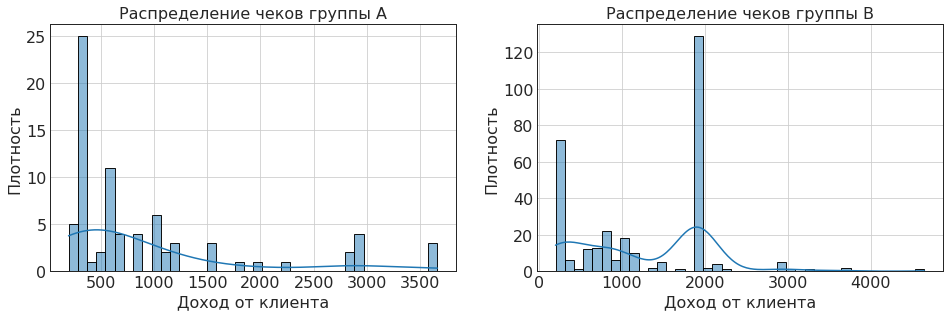

In [122]:
# По платящим
plt.subplot(2,2,1)
sns.histplot(active_A['rev'], bins = 40, kde = True,edgecolor='black')
plt.title('Распределение чеков группы А')
plt.xlabel('Доход от клиента')
plt.ylabel('Плотность')
plt.grid()
plt.subplot(2,2,2)
sns.histplot(active_B['rev'], bins = 40, kde = True,edgecolor='black')
plt.title('Распределение чеков группы B')
plt.xlabel('Доход от клиента')
plt.ylabel('Плотность')
plt.grid()

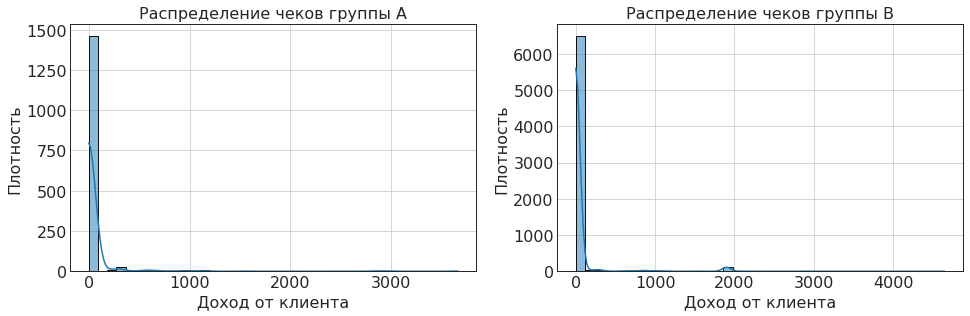

In [128]:
# По всем
plt.subplot(2,2,1)
sns.histplot(full_active[full_active['grp'] == 'A']['rev'], bins = 40, kde = True,edgecolor='black')
plt.title('Распределение чеков группы А')
plt.xlabel('Доход от клиента')
plt.ylabel('Плотность')
plt.grid()
plt.subplot(2,2,2)
sns.histplot(full_active[full_active['grp'] == 'B']['rev'], bins = 40, kde = True,edgecolor='black')
plt.title('Распределение чеков группы B')
plt.xlabel('Доход от клиента')
plt.ylabel('Плотность')
plt.grid()

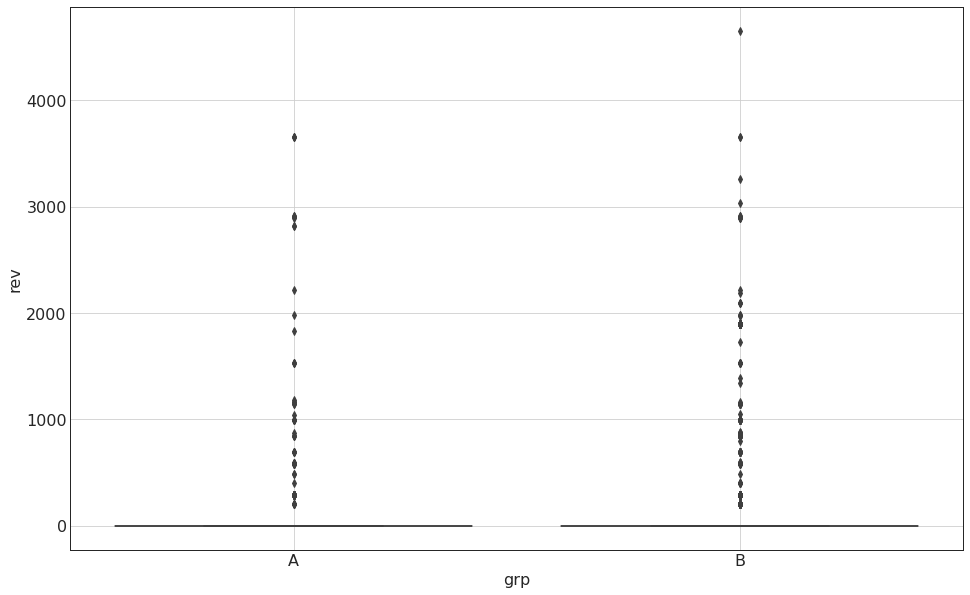

In [131]:
sns.boxplot(data = full_active, x = 'grp', y = 'rev')
plt.grid()

''

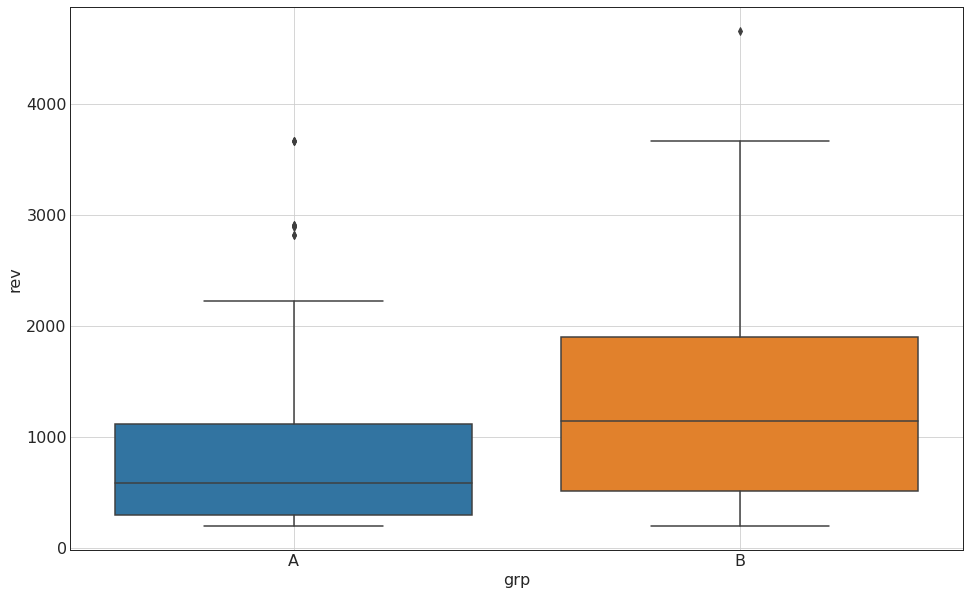

In [132]:
# Проверим распределение и выбросы по среднему платящему 
sns.boxplot(data = full_active.query('rev > 0'), x = 'grp', y = 'rev')
plt.grid()
;

Так как распределение данные ненормально проверим дисперсии

In [133]:
# Дисперсия по всем
stats.levene(full_active[full_active['grp'] == 'A']['rev'],full_active[full_active['grp'] == 'B']['rev'])

LeveneResult(statistic=1.501460829433639, pvalue=0.22048133327049665)

Дисперсия в группах не отличается значимо

In [134]:
# По платящим
stats.levene(full_active[full_active['grp'] == 'A'].query('rev > 0')['rev'],\
             full_active[full_active['grp'] == 'B'].query('rev > 0')['rev'])

LeveneResult(statistic=3.075681699981606, pvalue=0.08025675761347022)

Дисперсия в группах так же не отличается

## 1.3.2 Статистическая значимость:

Z-тест для конверсии и t-тест, так как дисперсии не отличаются, для ARPU и ARPPU позволяют сделать вывод о наличии значимых различий.

### Гипотеза для конверсии

- Н0 Нет никаких статистических различий **конвесии в оплату** между группами  
- Н1 Статистические различия **конверсии в оплату** между группами есть

In [135]:
#Используем Z-тест пропорций
count = metrics[['paying_users', 'total_users']].values.T
z_stat, p_value = proportions_ztest(count[0],count[1])

In [136]:
if p_value>=0.05:
    print(f'p-value = {p_value}','Статистических различий нет, отвергаем Н1 гипотезу', sep = '\n')
else:
    print(f'p-value = {p_value}','Статистические различия есть принимаем Н1 гипотезу',sep = '\n')

p-value = 0.445470284371589
Статистических различий нет, отвергаем Н1 гипотезу


### Гипотеза для среднего чека по всем пользователям

- Н0 Никаких статистических различий в **ARPU** между группами нет  
- Н1 Статистические различия в **ARPU** между группами есть

In [137]:
# t-тест по ARPU
group_a_arpu = full_active[full_active['grp'] == 'A']['rev']
group_b_arpu = full_active[full_active['grp'] == 'B']['rev']
u_stat, p_value_arpu = stats.ttest_ind(group_b_arpu, group_a_arpu, alternative='two-sided')
if p_value_arpu>=0.05:
    print(f'p-value = {p_value_arpu}','Статистических различий нет, отвергаем Н1 гипотезу', sep = '\n')
else:
    print(f'p-value = {p_value_arpu}','Статистические различия есть принимаем Н1 гипотезу', sep = '\n')

p-value = 0.22048133326988378
Статистических различий нет, отвергаем Н1 гипотезу


### Гипотеза для среднего чека по платящим пользователям

- Н0 Никаких статистических различий в **ARPPU** между группами нет  
- Н1 Статистические различия в **ARPPU** между группами есть

In [138]:
# t-тест по ARPPU
group_a_arppu = full_active[full_active['grp'] == 'A'].query('rev > 0')['rev']
group_b_arppu = full_active[full_active['grp'] == 'B'].query('rev > 0')['rev']
u_stat, p_value_arppu = stats.ttest_ind(group_b_arppu, group_a_arppu, alternative='two-sided')
if p_value_arppu>=0.05:
    print(f'p-value = {p_value_arppu}','Статистических различий нет, отвергаем Н1 гипотезу', sep = '\n')
else:
    print(f'p-value = {p_value_arppu}','Статистические различия есть принимаем Н1 гипотезу', sep = '\n')

p-value = 0.0018562025265765867
Статистические различия есть принимаем Н1 гипотезу


In [139]:
print(f'''
Результаты анализа:
Конверсия:
   - Группа A: {metrics.loc[0, 'conversion']:.2%}
   - Группа B: {metrics.loc[1, 'conversion']:.2%}
   - p-value: {p_value} {'(значимо)' if p_value < 0.05 else ''}

ARPU:
   - Группа A: {round(metrics.loc[0, 'arpu'],2)}
   - Группа B: {round(metrics.loc[1, 'arpu'],2)}
   - p-value: {p_value_arpu} {'(значимо)' if p_value_arpu < 0.05 else ''}
   
ARPPU:
   - Группа A: {round(metrics.loc[0, 'arppu'],2)}
   - Группа B: {round(metrics.loc[1, 'arppu'],2)} 
   - p-value: {p_value_arppu} {'(значимо)' if p_value_arppu < 0.05 else ''}
'''
)


Результаты анализа:
Конверсия:
   - Группа A: 5.07%
   - Группа B: 4.62%
   - p-value: 0.445470284371589 

ARPU:
   - Группа A: 47.35
   - Группа B: 58.06
   - p-value: 0.22048133326988378 
   
ARPPU:
   - Группа A: 933.59
   - Группа B: 1257.88 
   - p-value: 0.0018562025265765867 (значимо)



## 1.3.3 Вывод:

1. **Конверсия в платящего** пользователя и **ARPU** не показали различий между тестовой и контрольной группах.
2. В то же время **ARPPU** в тестовой группе стал значительно выше.

Каким-то образом новая механика оплаты стимулирует делать заказ на большую сумму, на графике виден всплеск покупок в районе 2000, вполне вероятно это может быть баг либо произошел отток малоплатящих пользователей.

Так же стоит учитывать момент, что у выборки сильный перекос в сторону тестовой группы от общего числа пользователей и это вполне могло отразиться на результате.

#### Итог
Мы не можем однозначно сказать стоит ли вносить изменения для всех пользователей т.к. нет информации на какую метрику планирует повлиять владелец бизнеса.  
Если стоит задача увеличить число платящих пользователей или **ARPU**, то новая система оплаты почти никак на них не влияет.  
Внедрение изменений из группы B целесообразно,только если бизнес ориентирован на монетизацию через платящих пользователей.  
Однако требуется дополнительный анализ:   
- Убедиться, что рост **ARPPU** не связан с какими либо событиями (например, временными акциями).
- Оценить влияние на retention
- Проверить динамику платящих пользователей

Если риски исключены, изменения можно раскатывать. Для роста общей выручки рекомендуется дополнительно работать над конверсией и привлечением новых платящих пользователей.

# Задание 2. SQL

## 2.1 Очень усердные ученики.


Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.

```SQL
SELECT
  COUNT(st_id)
from
  (
    SELECT
      st_id,
      count(correct)
    from
      peas
    WHERE
      correct = 'true'
    GROUP BY
      st_id
    HAVING
      count(correct) >= 20
  ) as stud
```

## 2.2 Оптимизация воронки

Необходимо в одном запросе выгрузить следующую информацию о группах пользователей:

- ARPU 
- ARPAU 
- CR в покупку 
- СR активного пользователя в покупку 
- CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике

ARPU считается относительно всех пользователей, попавших в группы.  
Активным считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.  
Активным по математике считается пользователь, за все время решивший 2 или больше задач правильно по математике.

```SQL
WITH active_users AS (-- собираем активных пользователей
  SELECT
    st_id
  FROM
    peas
  WHERE
    correct = 'true'
  GROUP BY
    st_id
  HAVING
    COUNT(correct) > 10
),
active_math_users AS ( -- собираем активных пользователей по математике
  SELECT
    st_id
  FROM
    peas
  WHERE
    subject = 'Math'
    AND correct = 'true'
  GROUP BY
    st_id
  HAVING
    COUNT(correct) >= 2
),
final_metrics AS ( --подготавливаем таблицу к расчетам метрик
  SELECT
    s.test_grp,
    COUNT(DISTINCT s.st_id) AS total_users, -- все пользователи
    COUNT(DISTINCT fpc.st_id) AS total_paying_users, -- все платящие
    COUNT(DISTINCT au.st_id) AS total_active_users, -- все активные пользователи
    COUNT(DISTINCT amu.st_id) AS total_active_math_users, -- все активные пользователи по математике
    SUM(fpc.money) AS total_revenue, -- общая выручка
    SUM(
      CASE
        WHEN au.st_id IS NOT NULL THEN fpc.money
        ELSE 0
      END
    ) AS total_revenue_active_users, -- выручка по активным пользователям
    SUM(
      CASE
        WHEN amu.st_id IS NOT NULL
        AND fpc.subject = 'Math' THEN fpc.money
        ELSE 0
      END
    ) AS total_revenue_active_math_users, -- выручка по активным математикам
    SUM(
      CASE
        WHEN amu.st_id IS NOT NULL
        AND fpc.subject = 'Math' THEN 1
        ELSE 0
      END
    ) * 1.0 / COUNT(DISTINCT amu.st_id) AS CR_math_active_purchase -- для удобства СR математиков считаю сразу
  FROM
    studs s
    LEFT JOIN final_project_check fpc ON s.st_id = fpc.st_id
    LEFT JOIN active_users au ON s.st_id = au.st_id
    LEFT JOIN active_math_users amu ON s.st_id = amu.st_id -- обьединение всех нужных таблиц
  GROUP BY
    s.test_grp 
)
SELECT
  test_grp, -- столбец с группами
  total_revenue / total_users as ARPU, --ARPU (общий доход / все пользователи)
  total_revenue_active_users / total_active_users as ARPAU, --ARPAU (доход от активных / активные пользователи)
  total_paying_users * 1.0 / total_users as CR,  --CR в покупку (пользователи с покупкой / все пользователи)
  total_paying_users * 1.0 / total_active_users AS CR_active_purchase, --CR активных в покупку(пользователи с покупкой/активные)
  CR_math_active_purchase
FROM
  final_metrics
```

# Задание 3. Python

## 3.1 Задача

#### Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла groups_add.csv (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.

Что бы не забивать место лишней информацией и повторением предыдущего кода, вынес код в отдельный файл .py

In [97]:
from final import calculate_metrics

In [98]:
metrics = calculate_metrics(groups)
# Функция делает расчеты как в первом задании дополнительно переписывая файл groups.csv,
# для будущих дополнений при поступлении новой информации

Группа: A
Всего пользователей: 1538
Платящие пользователи: 78.0
Общий доход: 72820.00
Конверсия: 5.07%
ARPU: 47.35
ARPPU: 933.59
------------------------------
Группа: B
Всего пользователей: 6803
Платящие пользователи: 314.0
Общий доход: 394974.00
Конверсия: 4.62%
ARPU: 58.06
ARPPU: 1257.88
------------------------------


In [99]:
metrics

,grp,total_users,paying_users,total_revenue,conversion,arpu,arppu
0,A,1538,78.0,72820.0000,0.050715,47.347204,933.589744
1,B,6803,314.0,394974.0035,0.046156,58.058798,1257.878992


#### Реализуйте функцию, которая будет строить графики по получаемым метрикам.

In [100]:
from final import visualizacion

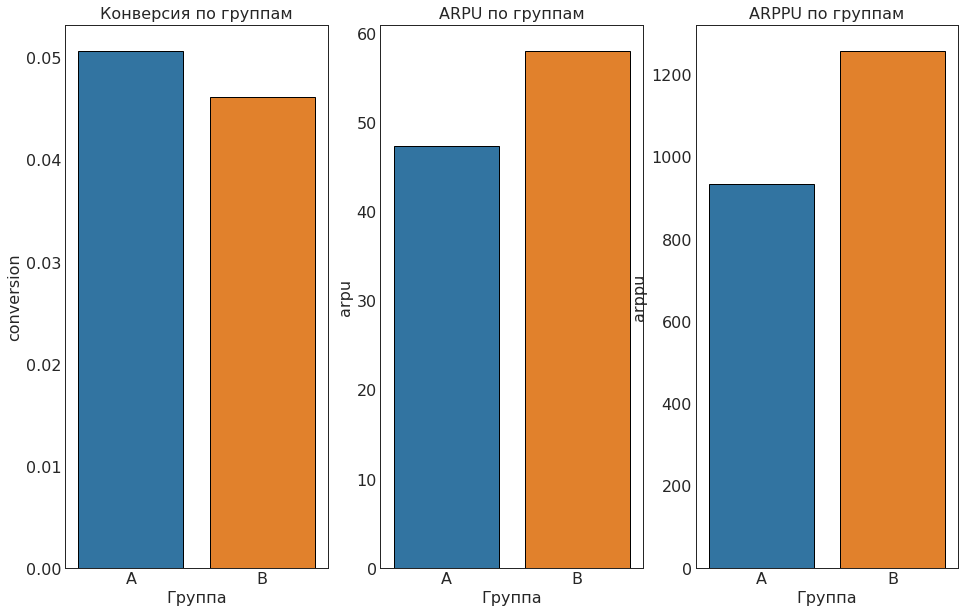

In [101]:
visualizacion(metrics)